In [1]:
from catboost import CatBoostClassifier
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler
from fancyimpute import IterativeImputer
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


# seed
# import os
# import random
# os.environ['PYTHONHASHSEED']=str(271828)
# random.seed(271828)
# np.random.seed(271828)


C:\Anaconda\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.
C:\Anaconda\lib\site-packages\tensorflow-2.0.0a0-py3.6-win-amd64.egg\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\lib\site-packages\tensorflow-2.0.0a0-py3.6-win-amd64.egg\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8

In [2]:

def PCL_calculator(df):

    symptomatic_cutoff = 2
    intrusion = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH', 'q6.4_UPSET', 'q6.5_PHYS']
    avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES', 'q6.9_DISINT', 'q6.10_DTACH',
                 'q6.11_NUMB', 'q6.12_FUTRE']
    tred = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH']
    only_avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES']
    hypertension = ['q6.13_SLEEP', 'q6.14_ANGER', 'q6.15_CONC', 'q6.16_HYPER', 'q6.17_STRTL']
    depression = ['q6.9_DISINT', 'q6.10_DTACH', 'q6.11_NUMB', 'q6.12_FUTRE']

    df[intrusion + avoidance + hypertension].fillna(df[intrusion + avoidance + hypertension].mean(axis=1))
    intrusion_cuoff = 1
    avoidance_cuoff = 3
    hypertension_cuoff = 2
    only_avoidance_cutoff = 1
    depression_cutoff = 2
    tred_cutoff = 1

    df['PCL_score'] = (df[intrusion + avoidance + hypertension]).sum(axis=1)
    df['PCL_mean'] = (df[intrusion + avoidance + hypertension]).mean(axis=1)
    df['PCL_std'] = (df[intrusion + avoidance + hypertension]).std(axis=1)
    

    df['intrusion'] = (df[intrusion] > symptomatic_cutoff).sum(axis=1)
    df['intrusion_mean'] = (df[intrusion] > symptomatic_cutoff).mean(axis=1)
    df['intrusion_std'] = (df[intrusion] > symptomatic_cutoff).std(axis=1)
    df['intrusion_cutoff'] = (df['intrusion'] >= intrusion_cuoff).astype(int)

    df['avoidance'] = (df[avoidance] > symptomatic_cutoff).sum(axis=1)
    df['avoidance_mean'] = (df[avoidance] > symptomatic_cutoff).mean(axis=1)
    df['avoidance_std'] = (df[avoidance] > symptomatic_cutoff).std(axis=1)
    df['avoidance_cutoff'] = (df['avoidance'] >= avoidance_cuoff).astype(int)

    df['depression'] = (df[depression] > symptomatic_cutoff).sum(axis=1)
    df['depression_mean'] = (df[depression] > symptomatic_cutoff).mean(axis=1)
    df['depression_std'] = (df[depression] > symptomatic_cutoff).std(axis=1)
    df['depression_cutoff'] = (df['depression'] >= depression_cutoff).astype(int)

    df['hypertention'] = (df[hypertension] > symptomatic_cutoff).sum(axis=1)
    df['hypertention_mean'] = (df[hypertension] > symptomatic_cutoff).mean(axis=1)
    df['hypertention_std'] = (df[hypertension] > symptomatic_cutoff).std(axis=1)
    df['hypertention_cutoff'] = (df['hypertention'] >= hypertension_cuoff).astype(int)

    df['tred'] = (df[tred] > symptomatic_cutoff).sum(axis=1)
    df['tred_mean'] = (df[tred] > symptomatic_cutoff).mean(axis=1)
    df['tred_std'] = (df[tred] > symptomatic_cutoff).std(axis=1)
    df['tred_cutoff'] = df['tred'] >= tred_cutoff

    df['only_avoidance'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_mean'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_std'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_cutoff'] = df['only_avoidance'] >= only_avoidance_cutoff

    #df['regression_cutoff_33'] = df['sum'] >= 33
    #df['regression_cutoff_50'] = df['sum'] >= 49
    df['diagnosis'] = ((df['hypertention_cutoff']) & (df['avoidance_cutoff']) & (df['intrusion_cutoff']) & (df['PCL_score'] >= 49))

    return df



In [3]:
path = "C:\‏‏PycharmProjects\PTSD\Data\PTSD.xlsx"
df = pd.read_excel(path)
#combine with specifics of answers
df_pcl2 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL2.xlsx")
df_pcl2 = PCL_calculator(df_pcl2)

df_pcl1 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL1.xlsx")
df_pcl1 = PCL_calculator(df_pcl1)

df = df.merge(df_pcl1, on="ID", how='outer')
df = df.merge(df_pcl2, suffixes=('_pcl1', '_pcl2'), on="ID", how='outer')

df_pcl3 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL3.xlsx")
df_pcl3 = PCL_calculator(df_pcl3)
df = df.merge(df_pcl3.drop(['PCL3_Strict', 'pcl3', 'PCL3_Broad'], axis=1), on="ID", how='outer')
# rmoving missing Y's
df = df[~df['tred_cutoff'].isna()]

## features 

In [4]:

features = ["T2Acc1t", "T2Acc1n", "military_exposure_unit",
    "highschool_diploma", "dyslexia", "ADHD", "T1Acc1t", "T1Acc1n", "T1bias", 'Ashken_scale', 'Sephar_scale',
            "phq1", "lot1", "trait1",
                "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "phq2", "lot2", "trait2", "state2", "PCL2", "PCL_Broad2",
                "PCL_Strict2", "cd_risc1", "active_coping1", "planning1", "positive_reframing1", "acceptance1",
                "humor1",
                "religion1", "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "active_coping2", "planning2",
                "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                "instrumental_support2",
                "self_distraction2", "denial2", "venting2", "substance_use2", "behavioral_disengagement2",
                "self_blame2",
                "trauma_history8_1", "HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5", 'q6.1_INTRU_pcl1', 
                'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                  'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                  'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                  'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                  'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                  'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                  'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                  'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2',
            
            'PCL_score_pcl1', 'PCL_mean_pcl1', 'PCL_std_pcl1', 'intrusion_pcl1', 'intrusion_mean_pcl1', 'intrusion_std_pcl1',
            'intrusion_cutoff_pcl1', 'avoidance_pcl1', 'avoidance_mean_pcl1', 'avoidance_std_pcl1', 'avoidance_cutoff_pcl1', 
            'depression_pcl1', 'depression_mean_pcl1', 'depression_std_pcl1', 'depression_cutoff_pcl1', 'hypertention_pcl1',
            'hypertention_mean_pcl1', 'hypertention_std_pcl1', 'hypertention_cutoff_pcl1', 'tred_pcl1', 'tred_mean_pcl1', 
            'tred_std_pcl1', 'tred_cutoff_pcl1', 'only_avoidance_pcl1','only_avoidance_mean_pcl1', 'only_avoidance_std_pcl1', 
            'only_avoidance_cutoff_pcl1',
            
            'PCL_score_pcl2', 'PCL_mean_pcl2', 'PCL_std_pcl2', 'intrusion_pcl2', 'intrusion_mean_pcl2', 'intrusion_std_pcl2',
            'intrusion_cutoff_pcl2', 'avoidance_pcl2', 'avoidance_mean_pcl2', 'avoidance_std_pcl2', 'avoidance_cutoff_pcl2', 
            'depression_pcl2', 'depression_mean_pcl2', 'depression_std_pcl2', 'depression_cutoff_pcl2', 'hypertention_pcl2',
            'hypertention_mean_pcl2', 'hypertention_std_pcl2', 'hypertention_cutoff_pcl2', 'tred_pcl2', 'tred_mean_pcl2', 
            'tred_std_pcl2', 'tred_cutoff_pcl2', 'only_avoidance_pcl2','only_avoidance_mean_pcl2', 'only_avoidance_std_pcl2', 
            'only_avoidance_cutoff_pcl2'
]

In [5]:
discrete_features = ["age", "highschool_diploma", "dyslexia", "ADHD", "phq1", "lot1",
                    "trait1", "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "phq2", "lot2",
                    "trait2", "state2", "PCL2", "PCL_Broad2", "PCL_Strict2", "cd_risc1", "active_coping1",
                    "planning1", "positive_reframing1", "acceptance1", "humor1", "religion1",
                    "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                    "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "active_coping2",
                    "planning2", "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                    "instrumental_support2", "self_distraction2", "denial2", "venting2", "substance_use2",
                    "behavioral_disengagement2", "self_blame2", "trauma_history8_1",
                    'q6.1_INTRU_pcl1', 'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                    'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                    'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                    'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                    'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                    'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                    'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                    'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2',
                    'intrusion_cutoff', 'avoidance_cutoff', 'hypertention_cutoff', 'regression_cutoff_50']

In [6]:
genome_features = ["HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5"]
continuous_features = ["T1Acc1t", "T1Acc1n", "T1bias"]
t2_features = [
    "lot2", "trait2", "state2", "PCL2", "PCL_Broad2", "PCL_Strict2", "phq2",

    "active_coping2", "planning2", "positive_reframing2", "acceptance2", "humor2", 
    "religion2", "emotional_support2", "instrumental_support2", "self_distraction2",
    "denial2", "venting2", "substance_use2", "behavioral_disengagement2", "self_blame2",
    
    'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2', 'q6.5_PHYS_pcl2',
    'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                    'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                    'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2'
]
t1_features =[ "phq1", "lot1", "trait1","state1", "PCL1", "PCL_Broad1", "PCL_Strict1",
              
                    "active_coping1", "planning1", "positive_reframing1", "acceptance1", "humor1", "religion1",
                    "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                    "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1",
                'q6.1_INTRU_pcl1', 'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                    'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                    'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                    'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1']

## fill the missing values

In [7]:
mtl_targets = ['intrusion_cutoff','hypertention_cutoff', 'avoidance_cutoff', 'depression_cutoff']
target_feature = ['tred_cutoff']

In [8]:
df1 = df[features + mtl_targets + target_feature]

#df1 = df1.dropna(thresh=47)
df_t1 = df1[t1_features]
df_t2 = df1[t2_features]
df1 = df1[(df_t1.isna().astype(int).sum(axis=1)<38) | (df_t2.isna().astype(int).sum(axis=1)<38)]
df1["t1_missing"] = df_t1.isna().astype(int).sum(axis=1)==38
df1["t2_missing"] = df_t2.isna().astype(int).sum(axis=1)==38
features.extend(["t1_missing", "t2_missing"])

impute = 1
if impute:
    for i in mtl_targets:
        df1[i] = df[i].fillna(0)
    mice = IterativeImputer()
    df1 = pd.DataFrame(mice.fit_transform(df1), columns=df1.columns)
    #Y = Y.fillna(Y.mean())
    features.extend(["outliers_count_t1_35", "outliers_count_t2_35", "outliers_count_t1_25", "outliers_count_t2_25"])
    df1["outliers_count_t1_35"] = (np.abs(stats.zscore(df1[t1_features])) > 3.5).sum(axis=1)
    df1["outliers_count_t1_25"] = (np.abs(stats.zscore(df1[t1_features])) > 2.5).sum(axis=1)
    df1["outliers_count_t2_35"] = (np.abs(stats.zscore(df1[t2_features])) > 3.5).sum(axis=1)
    df1["outliers_count_t2_25"] = (np.abs(stats.zscore(df1[t2_features])) > 2.5).sum(axis=1)
    
    
#df1 = df1[(np.abs(stats.zscore(df1)) > 3).sum(axis=1)<15]

In [9]:
#df1[features] =StandardScaler().fit_transform(df1[features]), columns=df1.columns)
df1['std_genome'] = df1[genome_features].std(axis=1)
df1['std_t2'] = df1[[ "trait2", "state2", "PCL2"]].std(axis=1)
df1['std_t1'] = df1[[ "trait1", "state1", "PCL1"]].std(axis=1)

df1['std_pos_coping_t1'] = df1[["active_coping1", "planning1", "positive_reframing1", "acceptance1", "humor1",
                "religion1", "emotional_support1", "instrumental_support1", "self_distraction1","venting1"]].std(axis=1)

df1['std_neg_coping_t1'] = df1[["denial1", "substance_use1", "behavioral_disengagement1", "self_blame1"]].std(axis=1)

df1['std_pos_coping_t2'] = df1[["active_coping2", "planning2", "positive_reframing2", "acceptance2", "humor2",
                "religion1", "emotional_support2", "instrumental_support2", "self_distraction2","venting2"]].std(axis=1)

df1['std_neg_coping_t2'] = df1[["denial2", "substance_use2", "behavioral_disengagement2", "self_blame2"]].std(axis=1)

features = features + ['std_genome', 'std_t1', 'std_t2', 'std_pos_coping_t1', 'std_neg_coping_t1', 'std_pos_coping_t2', 'std_neg_coping_t2']

In [10]:
for i in t1_features:
    df1["delta_"+i[:len(i)-1:]] = df1[i] - df1[i[:len(i)-1:]+"2"]
    features = features + ["delta_"+i[:len(i)-1:]]

In [11]:
z_features = ['std_genome', 'std_t1', 'std_t2', 'std_pos_coping_t1', 'std_neg_coping_t1', 'std_pos_coping_t2', 'std_neg_coping_t2'] + continuous_features

In [12]:
from scipy.stats import zscore
#for i in z_features:
 #   df1[i + "_z_Score"] = stats.zscore(df1[i])
  #  features = features + [i + "_z_Score"]
for i in genome_features:
    for j in ['Ashken_scale', 'Sephar_scale']:
        df1[i + "_" + j] = df1[i] * df1[j] * 0.01
        features = features + [i + "_" + j]
        

In [13]:
from statsmodels.formula.api import ols

m = ols('PCL_score_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
        'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
        'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
        'behavioral_disengagement1 + self_blame1',df1).fit()
infl = m.get_influence()
sm_fr = infl.summary_frame()
df1[['cooks_d_PCL_score_pcl2', 'dffits_PCL_score_pcl2', 'standard_resid_PCL_score_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']]
features = features + ['cooks_d_PCL_score_pcl2', 'dffits_PCL_score_pcl2', 'standard_resid_PCL_score_pcl2']


m = ols('intrusion_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
        'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
        'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
        'behavioral_disengagement1 + self_blame1',df1).fit()
infl = m.get_influence()
sm_fr = infl.summary_frame()
df1[['cooks_d_intrusion_pcl2', 'dffits_intrusion_pcl2', 'standard_resid_intrusion_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']]
features = features + ['cooks_d_intrusion_pcl2', 'dffits_intrusion_pcl2', 'standard_resid_intrusion_pcl2']



m = ols('avoidance_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
        'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
        'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
        'behavioral_disengagement1 + self_blame1',df1).fit()
infl = m.get_influence()
sm_fr = infl.summary_frame()
df1[['cooks_d_avoidance_pcl2', 'dffits_avoidance_pcl2', 'standard_resid_avoidance_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']]
features = features + ['cooks_d_avoidance_pcl2', 'dffits_avoidance_pcl2', 'standard_resid_avoidance_pcl2']


m = ols('depression_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
        'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
        'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
        'behavioral_disengagement1 + self_blame1',df1).fit()
infl = m.get_influence()
sm_fr = infl.summary_frame()
df1[['cooks_d_depression_pcl2', 'dffits_depression_pcl2', 'standard_resid_depression_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']]
features = features + ['cooks_d_depression_pcl2', 'dffits_depression_pcl2', 'standard_resid_depression_pcl2']


m = ols('hypertention_pcl2 ~ PCL_score_pcl1 + phq1 + lot1 + trait1 + state1 + active_coping1 + '\
        'planning1 + positive_reframing1 + acceptance1 + humor1 + religion1 + emotional_support1 + '\
        'instrumental_support1 + self_distraction1 + denial1 + venting1 + substance_use1 + '\
        'behavioral_disengagement1 + self_blame1',df1).fit()
infl = m.get_influence()
sm_fr = infl.summary_frame()
df1[['cooks_d_hypertention_pcl2', 'dffits_hypertention_pcl2', 'standard_resid_hypertention_pcl2']] = sm_fr[['cooks_d', 'dffits', 'standard_resid']]
features = features + ['cooks_d_hypertention_pcl2', 'dffits_hypertention_pcl2', 'standard_resid_hypertention_pcl2']

In [14]:

useless_features = ["dyslexia","T1Acc1n", 'Ashken_scale', 'Sephar_scale', "phq1", "lot1", "trait1",
                "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "state2", "PCL_Broad2",
                "PCL_Strict2", "active_coping1", "planning1", "positive_reframing1", "acceptance1",
                "humor1", "religion1", "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "planning2",
                "religion2", "instrumental_support2", "venting2", "behavioral_disengagement2",
                "trauma_history8_1", "HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5", 'q6.1_INTRU_pcl1', 
                'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                  'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                  'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                  'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                
                    'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                  'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                  'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                  'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2',
            
            'PCL_score_pcl1', 'PCL_mean_pcl1', 'intrusion_mean_pcl1', 'intrusion_cutoff_pcl1', 'avoidance_pcl1',
            'avoidance_mean_pcl1', 'avoidance_std_pcl1', 'avoidance_cutoff_pcl1', 
            'depression_pcl1', 'depression_mean_pcl1', 'depression_cutoff_pcl1', 'hypertention_pcl1',
            'hypertention_mean_pcl1', 'hypertention_cutoff_pcl1', 'tred_pcl1', 'tred_mean_pcl1', 
            'tred_std_pcl1', 'tred_cutoff_pcl1', 'only_avoidance_pcl1','only_avoidance_mean_pcl1', 'only_avoidance_std_pcl1', 
            'only_avoidance_cutoff_pcl1',
            
            'PCL_score_pcl2', 'PCL_mean_pcl2', 'PCL_std_pcl2', 'intrusion_pcl2',
            'intrusion_cutoff_pcl2',  'avoidance_cutoff_pcl2', 
            'depression_pcl2', 'depression_mean_pcl2', 'depression_cutoff_pcl2', 'hypertention_pcl2',
            'hypertention_cutoff_pcl2', 'tred_pcl2', 'tred_mean_pcl2', 
            'tred_std_pcl2', 'tred_cutoff_pcl2', 'only_avoidance_pcl2','only_avoidance_mean_pcl2', 
                    'only_avoidance_std_pcl2', 
            'only_avoidance_cutoff_pcl2',
                    
            
]


features = [i for i in features if i not in useless_features]

## target imbalance

## cut off the test set

In [15]:
X, X_out, Y, y_out = train_test_split(df1[features + mtl_targets], df1[target_feature[0]],
                                      test_size=0.25, random_state=271828, stratify=df1[target_feature[0]])


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=271828)
#ss, tt = StandardScaler(), StandardScaler()
#X_train, X_test = pd.DataFrame(np.hstack([ss.fit_transform(X_train[features]), X_train[mtl_targets]]), columns=X_train.columns), pd.DataFrame(np.hstack([tt.fit_transform(X_test[features]), X_test[mtl_targets]]), columns=X_test.columns)
cv = StratifiedKFold(10, random_state=271828)  

## the Model

## CV model of roc auc 

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


depth= 3 l2_leaf_reg= 5 class_weights= [1, 20] n_features_to_select= 100


C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


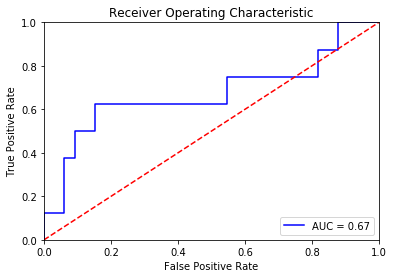

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


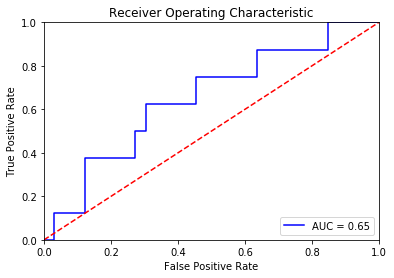

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


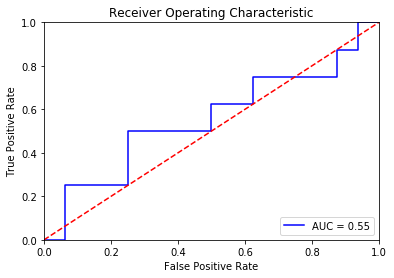

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


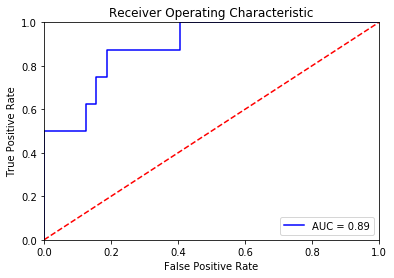

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


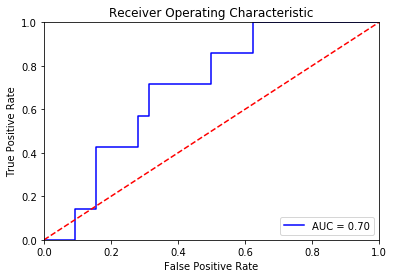

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


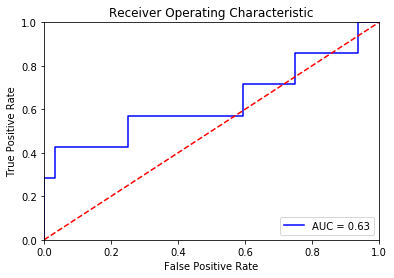

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


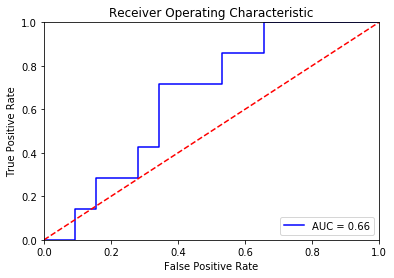

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


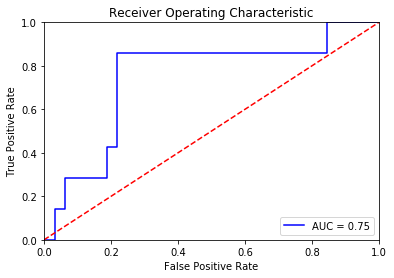

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


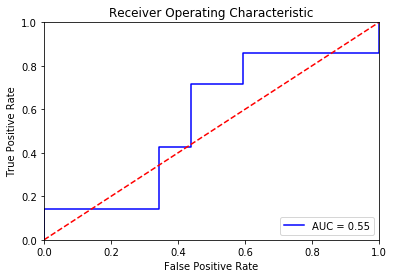

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


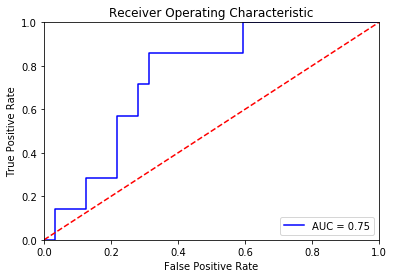

depth= 3 l2_leaf_reg= 5 class_weights= [1, 20] n_features_to_select= 50


C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


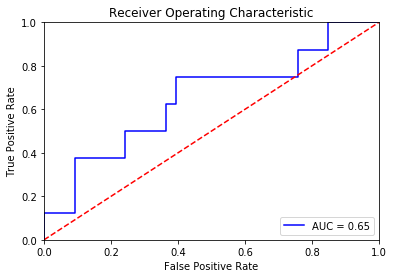

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


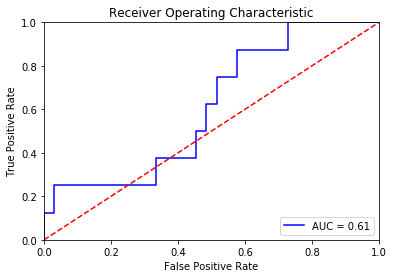

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


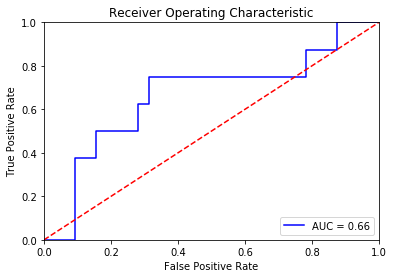

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


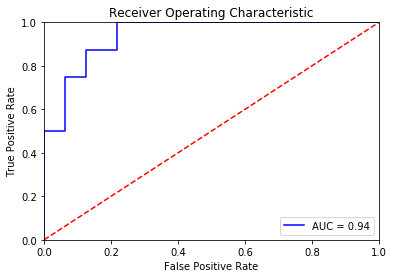

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


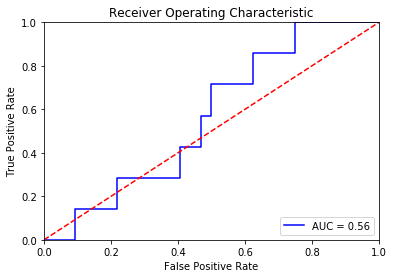

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


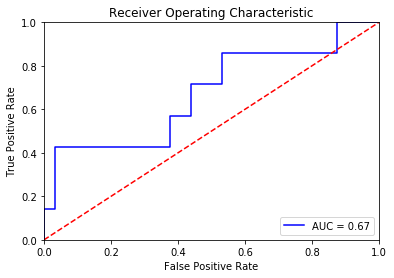

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


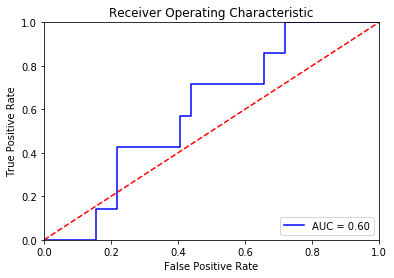

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


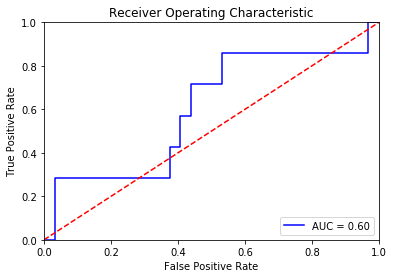

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


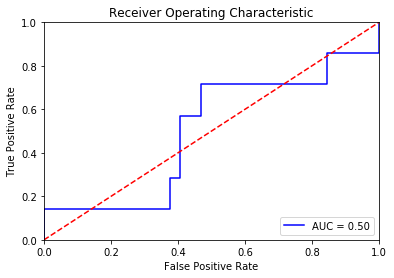

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


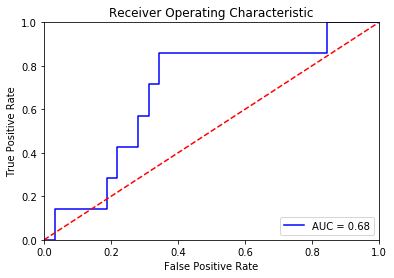

depth= 3 l2_leaf_reg= 5 class_weights= [1, 20] n_features_to_select= 25


C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


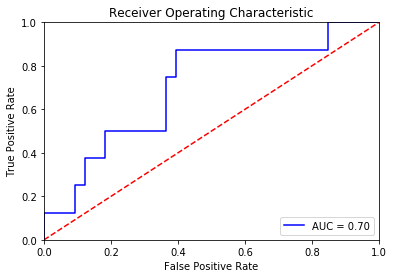

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


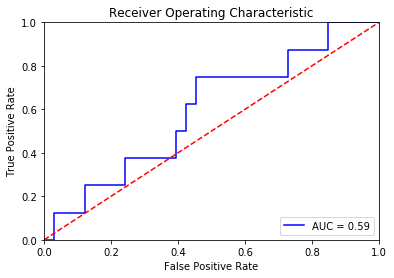

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


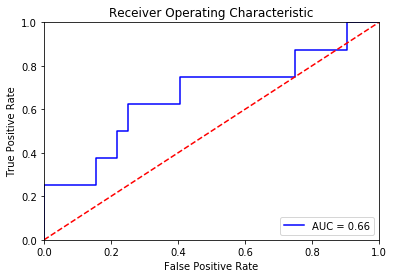

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


CatBoostError: bad allocation

In [18]:
scores_f = []
scores_p = []
scores_r = []
scores_auc = []
for depth in [3]:
    for class_weights in [[1, 20]]:
        for n_features_to_select in [100, 50, 25]:
            for l2_leaf_reg in [5]:
                print("depth=",depth, "l2_leaf_reg=",l2_leaf_reg, "class_weights=",class_weights, "n_features_to_select=",n_features_to_select)
                for train, test in cv.split(X_train, y_train.astype(int)):

                    X_train_cv = X_train.iloc[train]
                    y_train_cv = y_train.iloc[train]
                    X_test_cv = X_train.iloc[test]
                    t = [X_train_cv[i] for i in mtl_targets] + [y_train_cv]
                    X_train_cv.drop(mtl_targets, axis=1, inplace=True)
                    X_test_cv.drop(mtl_targets, axis=1, inplace=True)

                    clf_target = Pipeline([
                                  ('feature_selection', RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=n_features_to_select)),
                                  ('classification', CatBoostClassifier(verbose=0, class_weights=[class_weights[0], 4*class_weights[1]], depth=depth, l2_leaf_reg=l2_leaf_reg, loss_function='Logloss'))
                                ])

                  
                    y_pred_target = clf_target.fit(X_train_cv, t[3].values.astype(int)).predict_proba(X_test_cv)

                    #preds = (y_pred_1[:, 1] * y_pred_2[:, 1] *  y_pred_3[:, 1] * y_pred_target[:, 1]) > 0.02625 #+ 0.5 * y_pred_target[:, 1]) > 1

                    fpr, tpr, threshold = roc_curve(y_train.iloc[test], y_pred_target[:, 1])
                    roc_auc = auc(fpr, tpr)

                    # method I: plt
                    plt.title('Receiver Operating Characteristic')
                    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
                    plt.legend(loc = 'lower right')
                    plt.plot([0, 1], [0, 1],'r--')
                    plt.xlim([0, 1])
                    plt.ylim([0, 1])
                    plt.ylabel('True Positive Rate')
                    plt.xlabel('False Positive Rate')
                    plt.show()

In [ ]:
scores_auc

In [ ]:
scores_r

In [ ]:
scores_p

In [ ]:
scores_f

In [ ]:

t = [X_train[i] for i in mtl_targets] + [y_train]
X_train.drop(mtl_targets, axis=1, inplace=True)
    
y_pred_1 = CatBoostClassifier(verbose=0, loss_function='CrossEntropy', n_estimators=1000).fit(X_train, (t[0]).values.astype(int)).predict_proba(X_test)
y_pred_2 = CatBoostClassifier(verbose=0, loss_function='CrossEntropy', n_estimators=1000).fit(X_train, (t[1]).values.astype(int)).predict_proba(X_test)
y_pred_3 = CatBoostClassifier(verbose=0, loss_function='CrossEntropy', n_estimators=1000).fit(X_train, (t[2]).values.astype(int)).predict_proba(X_test)
y_pred_target = CatBoostClassifier(verbose=0, loss_function='CrossEntropy', n_estimators=1000).fit(X_train, t[3].values.astype(int)).predict_proba(X_test)

y_pred = (y_pred_1[:, 1] * y_pred_2[:, 1] *  y_pred_3[:, 1] * y_pred_target[:, 1]) > 0.0625 #+ 0.5 * y_pred_target[:, 1]) > 1

print("f1", f1_score(y_test.astype(bool), y_pred))
print("p",precision_score(y_test.astype(bool), y_pred))
print("r",recall_score(y_test.astype(bool), y_pred))
print("auc", roc_auc_score(y_test.astype(bool), y_pred))

In [ ]:
X, X_out, Y, y_out

In [ ]:

t = [X[i] for i in mtl_targets] + [Y]
X.drop(mtl_targets, axis=1, inplace=True)    
y_pred_1 = CatBoostClassifier(verbose=0, loss_function='CrossEntropy', n_estimators=100).fit(X, (t[0]).values.astype(int)).predict_proba(X_out)
y_pred_2 = CatBoostClassifier(verbose=0, loss_function='CrossEntropy', n_estimators=100).fit(X, (t[1]).values.astype(int)).predict_proba(X_out)
y_pred_3 = CatBoostClassifier(verbose=0, loss_function='CrossEntropy', n_estimators=100).fit(X, (t[2]).values.astype(int)).predict_proba(X_out)
y_pred_target = CatBoostClassifier(verbose=0, loss_function='CrossEntropy', n_estimators=100).fit(X, t[3].values.astype(int)).predict_proba(X_out)

y_pred = (y_pred_1[:, 1] * y_pred_2[:, 1] *  y_pred_3[:, 1] * y_pred_target[:, 1]) > 0.0625 #+ 0.5 * y_pred_target[:, 1]) > 1

print("f1", f1_score(y_out.astype(bool), y_pred))
print("p",precision_score(y_out.astype(bool), y_pred))
print("r",recall_score(y_out.astype(bool), y_pred))
print("auc", roc_auc_score(y_out.astype(bool), y_pred))